In [2]:
import climlab
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import scipy as sp
import xarray as xr

In [48]:
def getEquilRadConvColumn(
        return_model=False,
        num_lev=20,
        relHum=0.8,
        lapseRate=6,
        integrate_years=5,
        water_depth=5.,
        do_conv=True,
        albedo=0.3,
        CO2=0.000348,
        CH4=1.65e-06,
        N2O=3.06e-07,
        O2=0.21,
        CFC11=0.0,
        CFC12=0.0,
        CFC22=0.0,
        CCL4=0.0,
        O3_profile=np.array([5.38853507e-06, 9.86362297e-07, 3.46334801e-07, 1.90806332e-07,
                                    1.19700066e-07, 7.69083554e-08, 5.97316411e-08, 5.27011190e-08,
                                    4.80406196e-08, 4.44967931e-08, 4.18202246e-08, 3.99595858e-08,
                                    3.83838549e-08, 3.66179869e-08, 3.42885526e-08, 3.18505117e-08,
                                    2.93003951e-08, 2.69906527e-08, 2.49122466e-08, 2.28798533e-08]),
        O3fac=1.0,
        insolation=341.,
        cldfrac=0., 
        clwp=0., 
        ciwp = 0.,
        r_liq = 0.,
        r_ice = 0.,
        ):
    
    '''
    Mostly used as an interface to make it easy to 
    remember what the default GHGs are and change them
    '''

    # get the different components of the model
    # state - container for the vertical temperature profile
    # water vapour - set moisture based on relative humidity profile        
    # convection - hard convective adjustment
    # radiation - RRTM spectral radiation 

    state = climlab.column_state(num_lev=num_lev,
                                 num_lat=1,
                                 water_depth=water_depth)

    water_vapor = climlab.radiation.water_vapor.FixedRelativeHumidity(state=state,
                                                                        relative_humidity=relHum,
                                                                        name='Constant Relative Humidity')
    
#    state['q'] = water_vapor.q

    if do_conv:
        convection = climlab.convection.ConvectiveAdjustment(name='Convective Adjustment',
                                                  state=state,
                                                  adj_lapse_rate=lapseRate)    

    # create the ghg dict
    ghgDict = {'CO2': CO2,
                'CH4': CH4,
                'N2O': N2O,
                'O2': O2,
                'CFC11': CFC11,
                'CFC12': CFC12,
                'CFC22': CFC22,
                'CCL4': CCL4,
                'O3': O3fac*O3_profile}

    radiation = climlab.radiation.CAM3(name='Radiation',
                             state=state,
                             specific_humidity=water_vapor.q,
                             absorber_vmr=ghgDict,
                             cldfrac=cldfrac,
                             clwp=clwp,
                             ciwp=ciwp,
                             r_liq=r_liq,
                             r_ice=r_ice,
                             insolation=insolation,
                             return_spectral_olr=True,
                             albedo=albedo)


    # combine the components of the model together 
    if do_conv:
        model = climlab.couple([radiation,convection,water_vapor], name='RadConv')
    else:
        model = climlab.couple([radiation,water_vapor], name='RadOnly')

    # actually run the model 
    model.integrate_converge()

    model.compute_diagnostics()

    if return_model:
        return model
    else:
        return model.to_xarray(diagnostics=True)

In [52]:
def getOLRDiagnostic(
        input_state_Ts,
        input_state_Tatm,
        relHum=0.8,
        CO2=0.000348,
        CH4=1.65e-06,
        N2O=3.06e-07,
        O2=0.21,
        CFC11=0.0,
        CFC12=0.0,
        CFC22=0.0,
        CCL4=0.0,
        O3_profile=np.array([5.38853507e-06, 9.86362297e-07, 3.46334801e-07, 1.90806332e-07,
                                    1.19700066e-07, 7.69083554e-08, 5.97316411e-08, 5.27011190e-08,
                                    4.80406196e-08, 4.44967931e-08, 4.18202246e-08, 3.99595858e-08,
                                    3.83838549e-08, 3.66179869e-08, 3.42885526e-08, 3.18505117e-08,
                                    2.93003951e-08, 2.69906527e-08, 2.49122466e-08, 2.28798533e-08]),
        O3fac=1.0,
        insolation=341.,
        cldfrac=0., 
        clwp=0., 
        ciwp = 0.,
        r_liq = 0.,
        r_ice = 0.,
        albedo=0.1,
        ):

    # get the different components of the model
    # state - container for the vertical temperature profile
    # water vapour - set moisture based on relative humidity profile        
    # radiation - RRTM spectral radiation 

    # create the ghg dict
    ghgDict = {'CO2': CO2,
                'CH4': CH4,
                'N2O': N2O,
                'O2': O2,
                'CFC11': CFC11,
                'CFC12': CFC12,
                'CFC22': CFC22,
                'CCL4': CCL4,
                'O3': O3fac*O3_profile}

    # this is necessary because we output the states to xarray,
    # so have to convert back to state.    
    state = climlab.column_state(num_lev=len(input_state_Tatm), num_lat=1)
    state['Ts'][:] = input_state_Ts
    state['Tatm'][:] = input_state_Tatm

    water_vapor = climlab.radiation.water_vapor.FixedRelativeHumidity(state=state,
                                                                        relative_humidity=relHum)

    radiation = climlab.radiation.CAM3(name='Radiation',
                             state=state,
                             specific_humidity=water_vapor.q,
                             absorber_vmr=ghgDict,
                             cldfrac=cldfrac,
                             clwp=clwp,
                             ciwp=ciwp,
                             r_liq=r_liq,
                             r_ice=r_ice,
                             insolation=insolation,
                             return_spectral_olr=True,
                             albedo=albedo)

    radiation.compute_diagnostics()

    # output the data as an xarray dataset
    return radiation.to_xarray(diagnostics=True)

# Example: Radiation Balance and Solar Absorption

Imagine that we change the insolation, how will this impact the temperature profiles?

To test this, we will run the column twice, once in the default control, and once with a new insolation, then make some plots to see what happened.

In [49]:
ds0 = getEquilRadConvColumn()
dsA = getEquilRadConvColumn(insolation=300)

Total elapsed time is 5.996021270269426 years.
Total elapsed time is 7.994695027025902 years.


In [50]:
# check what diagnostics are available

ds0

<xarray.Dataset> Size: 3kB
Dimensions:           (depth: 1, lev: 20, lev_bounds: 21, depth_bounds: 2)
Coordinates:
  * depth             (depth) float64 8B 2.5
  * lev               (lev) float64 160B 25.0 75.0 125.0 ... 875.0 925.0 975.0
  * depth_bounds      (depth_bounds) float64 16B 0.0 5.0
  * lev_bounds        (lev_bounds) float64 168B 0.0 50.0 100.0 ... 950.0 1e+03
Data variables: (12/29)
    Ts                (depth) float64 8B 284.5
    Tatm              (lev) float64 160B 212.5 211.6 211.9 ... 277.9 280.6 283.2
    OLR               (depth) float64 8B 245.6
    OLRclr            (depth) float64 8B 245.6
    OLRcld            (depth) float64 8B 0.0
    TdotLW            (lev) float64 160B -3.239 -0.6498 ... -0.6939 -0.8534
    ...                ...
    SW_flux_down      (lev_bounds) float64 168B 341.0 321.2 ... 229.6 224.7
    SW_flux_net       (lev_bounds) float64 168B 245.6 226.4 ... 161.3 157.3
    SW_flux_up_clr    (lev_bounds) float64 168B 95.44 94.81 ... 68.31 67.42
    SW_flux_down_clr  (lev_bounds) float64 168B 341.0 321.2 ... 229.6 224.7
    SW_flux_net_clr   (lev_bounds) float64 168B 245.6 226.4 ... 161.3 157.3
    q                 (lev) float64 160B 0.000348 0.0001024 ... 0.006294

(1000.0, 0.0)

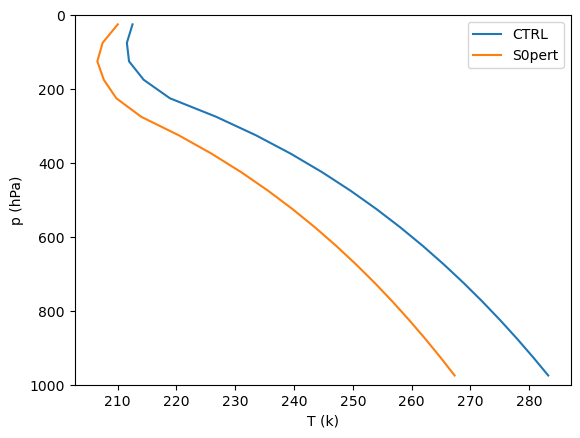

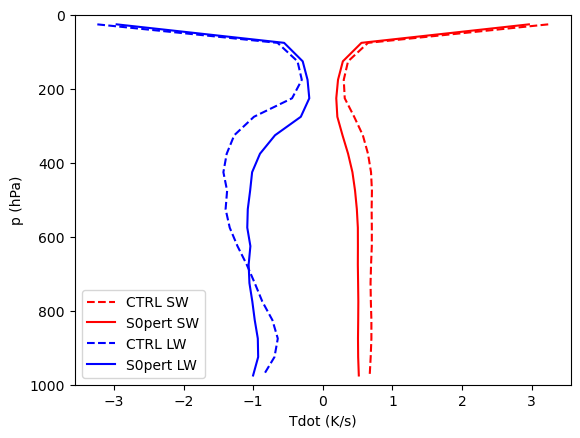

In [22]:
# lets plot the temperature profiles

plt.figure(0)
plt.plot(ds0.Tatm, ds0.lev, label='CTRL')
plt.plot(dsA.Tatm, ds0.lev, label='S0pert')
plt.xlabel('T (k)')
plt.ylabel('p (hPa)')
plt.legend()
plt.ylim([1e3,0])

# the warming is large near the surface, lets take a look at the heating rates

plt.figure(1)
plt.plot(ds0.TdotSW, ds0.lev, 'r--', label='CTRL SW',)
plt.plot(dsA.TdotSW, ds0.lev, 'r-', label='S0pert SW')
plt.plot(ds0.TdotLW, ds0.lev, 'b--', label='CTRL LW',)
plt.plot(dsA.TdotLW, ds0.lev, 'b-', label='S0pert LW')
plt.xlabel('Tdot (K/s)')
plt.ylabel('p (hPa)')
plt.legend()
plt.ylim([1e3,0])

# from the figure, we see that the shortwave heating change is vertically homogenous
# while the longwave heating has some structure to it.
# what do you think explains this difference? 

In [23]:
# this is for plotting the solutions 

def makePlotsFromExperimentList(rl,labell,
colorlist=['black','blue','red','green','orange','purple'],
plotDiff=False,
outputname=None
):

    titles=['T (K)','q(kg/kg)','','SW Flux (W/m^2)','LW Flux (W/m^2)','Heating Rates (K/day)']

    fig,axs=plt.subplots(2,3,figsize=(12,10),dpi=100)

    fig.delaxes(axs[0,-1])

    nl=range(0,len(rl))

    for n,r,l,c in zip(nl,rl,labell,colorlist):

        if plotDiff:
            r=r-rl[0]

        # temperature
        axs[0,0].plot(r.Tatm,r.lev,
                    label=l,color=c)

        # moisture
        axs[0,1].plot(r.q,r.lev,
                      label=l,color=c)

        if n==0:
            label0='FluxUp'
            label1='FluxDown'
            label2='FluxNet'
        else:
            label0=None
            label1=None
            label2=None
 
        # shortwave
        axs[1,0].plot(r.SW_flux_up,r.lev_bounds,
                      label=label0,color=c,linestyle='--')
        axs[1,0].plot(r.SW_flux_down,r.lev_bounds,
                      label=label1,color=c,linestyle='-.')
        axs[1,0].plot(r.SW_flux_net,r.lev_bounds,
                      label=label2,color=c,linestyle='-')
        
        # longwave
        axs[1,1].plot(r.LW_flux_up,r.lev_bounds,
                      label=label0,color=c,linestyle='--')
        axs[1,1].plot(r.LW_flux_down,r.lev_bounds,
                      label=label1,color=c,linestyle='-.')
        axs[1,1].plot(r.LW_flux_net,r.lev_bounds,
                      label=label2,color=c,linestyle='-')
        
        if n==0:
            label0='SW'
            label1='LW'
            label2='Conv'
        else:
            label0=None
            label1=None
            label2=None

        # heating rates
        axs[1,2].plot(r.TdotSW,r.lev,
                        color=c,label=label0,linestyle='--')
        axs[1,2].plot(r.TdotLW,r.lev,
                        color=c,label=label1,linestyle='-.')
        axs[1,2].plot(-r.TdotLW-r.TdotSW,r.lev,
                        color=c,label=label2,linestyle='-')

    for i,j in product(range(0,2),range(0,3)):
        axs[i,j].set_ylim([1e3,0])
        axs[i,j].set_title(titles[3*i+j])
        axs[i,j].set_ylabel('p (hPa)')

    axs[0,0].legend()
    axs[1,0].legend()
    axs[1,-1].legend()

    fig.tight_layout()

    if not outputname is None:
        plt.savefig(outputname)

    plt.show()

# 1 Sensitivity to Convection
## 1.1 Rad eq vs Rad-Conv eq
1. Calculate and compare the temperature and humidity profiles from a radiative equillibriated and radiative-convective equillibriated column. What causes the differences?
2. How would you calculate the convective heating rate from the model output? What does this imply about the surface fluxes?
## 1.2 Changes in the Lapse Rate 
1. Change the lapse rate and relative humidies in the convection scheme. What impacts do these have on the vertical structure of temperature and convective heating rates?

Total elapsed time is 7.994695027025902 years.


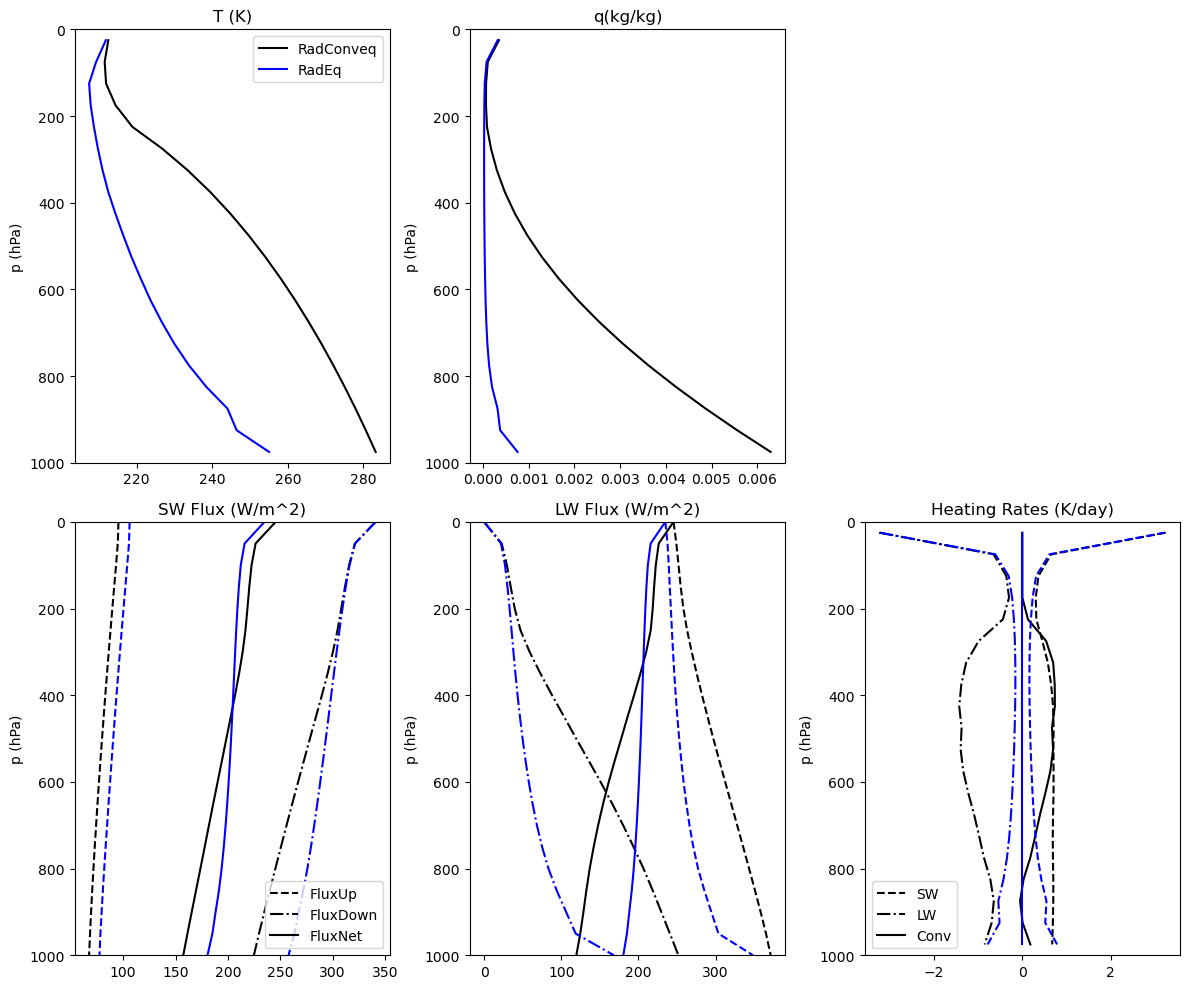

In [54]:
# 1.1
dsR=getEquilRadConvColumn(do_conv=False)
makePlotsFromExperimentList([ds0,dsR],['RadConveq','RadEq'])

Total elapsed time is 6.995358148647664 years.
Total elapsed time is 6.995358148647664 years.


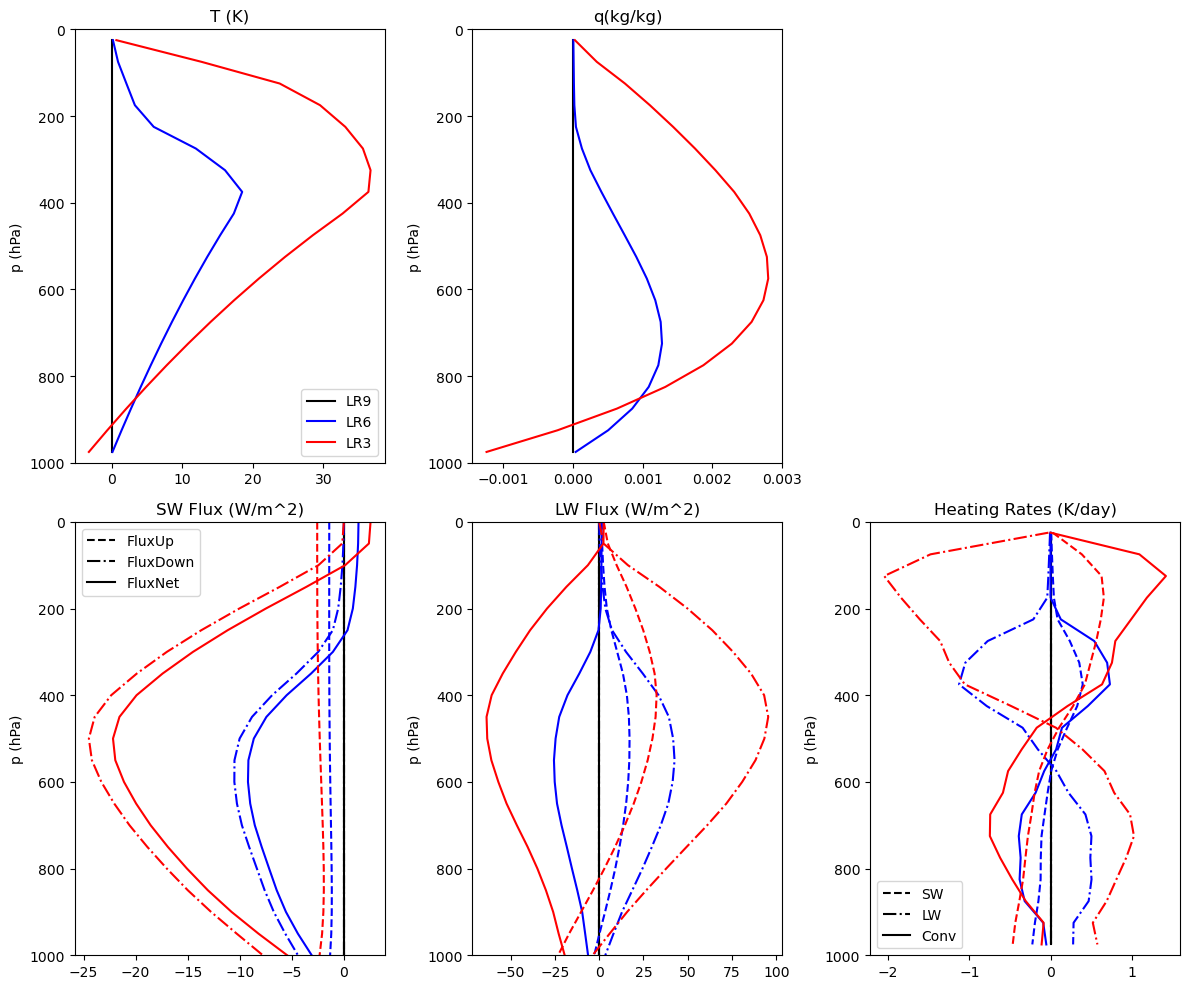

In [58]:
# 1.2
dsLR9=getEquilRadConvColumn(lapseRate=9)
dsLR3=getEquilRadConvColumn(lapseRate=3)
makePlotsFromExperimentList([dsLR9,ds0,dsLR3],['LR9','LR6','LR3'],plotDiff=True)

Total elapsed time is 6.995358148647664 years.
Total elapsed time is 6.995358148647664 years.


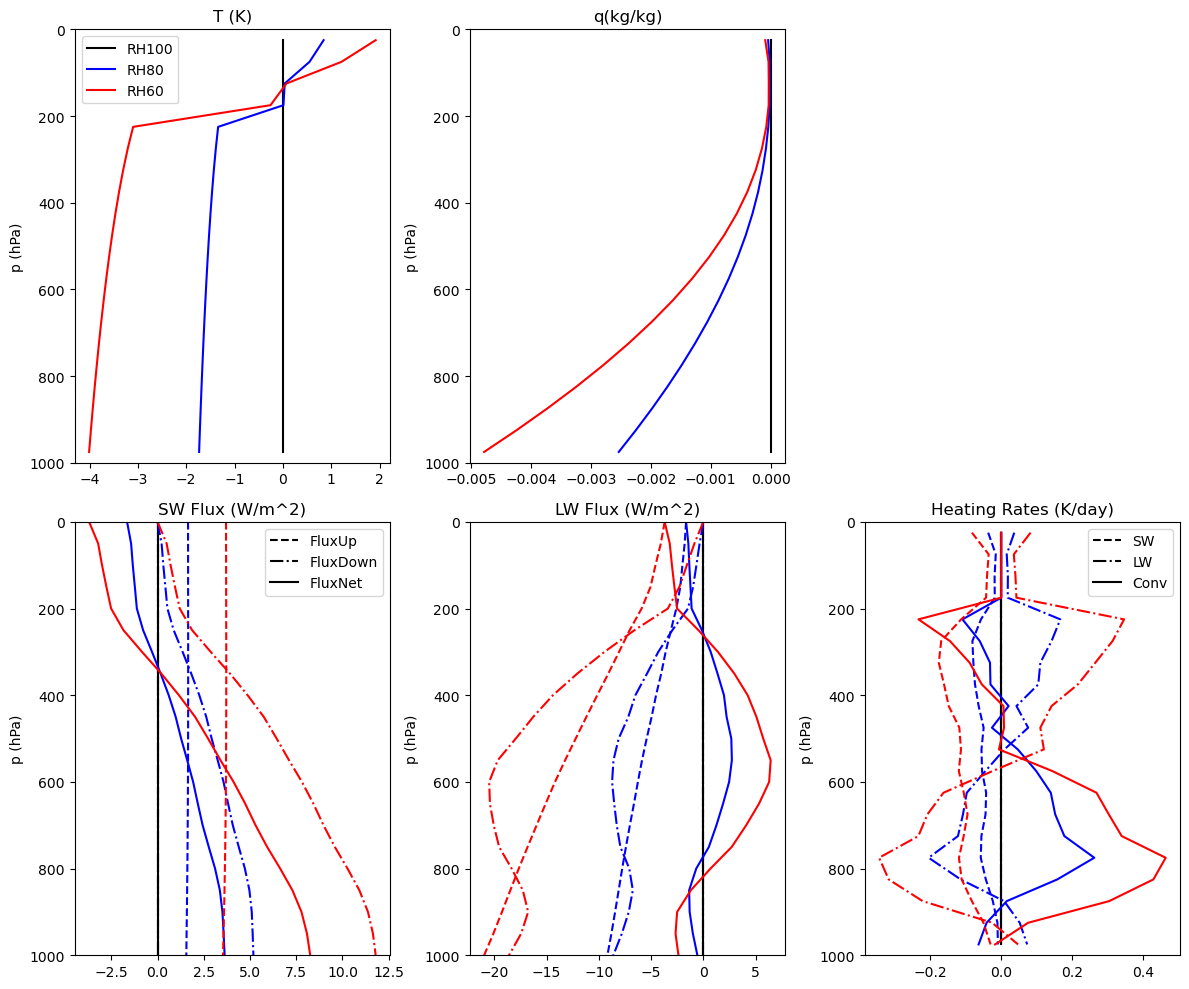

In [59]:
# 1.2
dsRH100=getEquilRadConvColumn(relHum=1.0)
dsRH60=getEquilRadConvColumn(relHum=0.6)
makePlotsFromExperimentList([dsRH100,ds0,dsRH60],['RH100','RH80','RH60'],plotDiff=True)

# 2 Cloud Radiative Effects 
1. Compute radiative-convective columns with the following cloud profiles (adapted from Table 3.3 in Hartman):

Low Cloud: central pressure = 825, liquid water path = 100

High Cloud: central pressure = 175, ice water path = 30

with the radius for everything 15 microns. 

2. How do the SW and LW fluxes interact with each cloud type?

3. What are the SW and LW changes to the TOA energy fluxes? Are these changes required to balance? 

4. What are the SW and LW changes to the surface energy fluxes? Are these changes required to balance? 

Total elapsed time is 5.996021270269426 years.
<xarray.DataArray 'lev' ()> Size: 8B
array(175.)
Coordinates:
    lev      float64 8B 175.0
Attributes:
    units:    mb
Total elapsed time is 9.993368783782378 years.
Total elapsed time is 9.993368783782378 years.


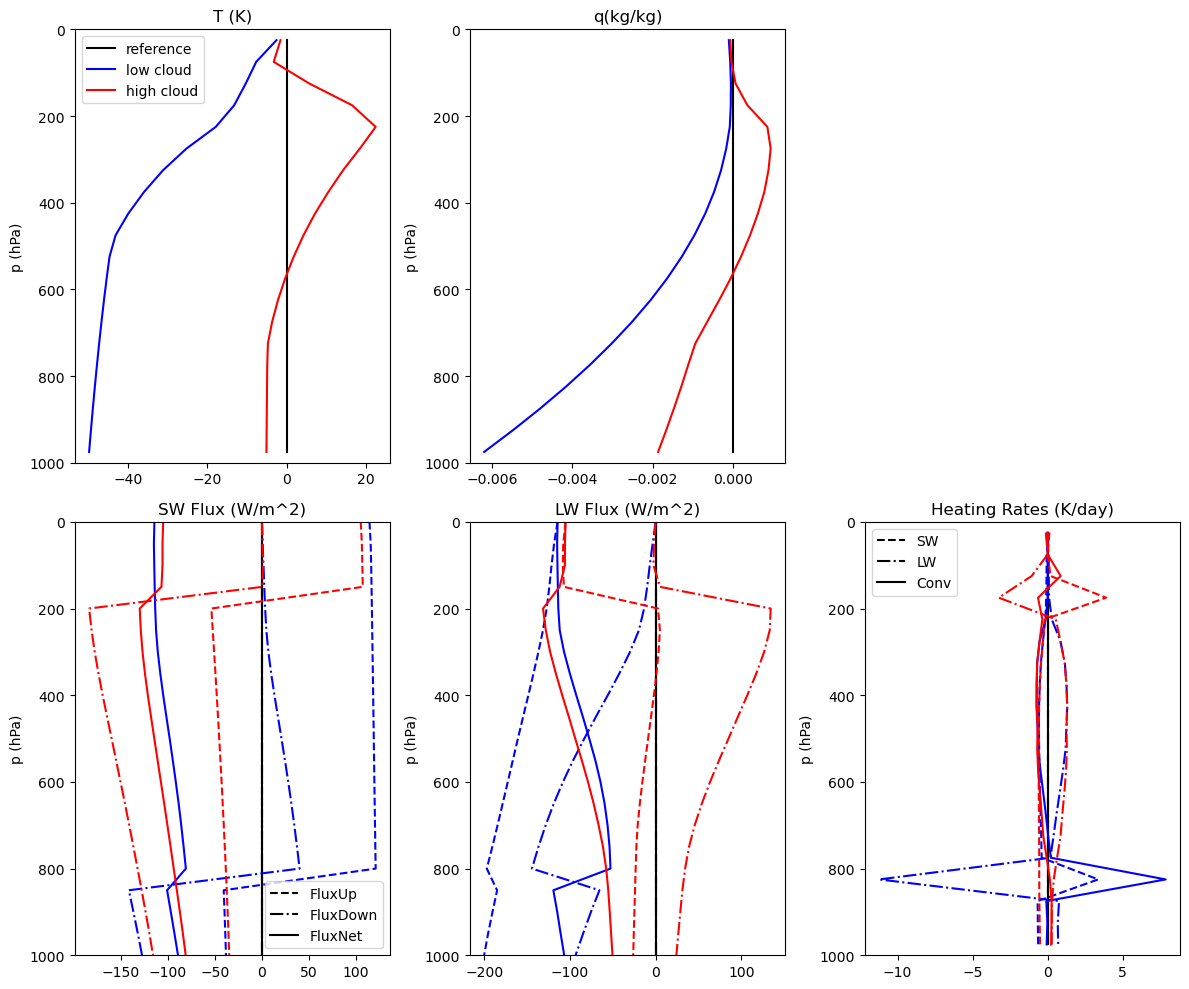

In [75]:
r0 = getEquilRadConvColumn()

nlev = len(r0.lev)

ilo=-4
cldfaclo=np.zeros(nlev);clplo=np.zeros(nlev); ciplo=np.zeros(nlev)
cldfaclo[ilo]=1; clplo[ilo]=100.; ciplo[ilo]=0.0

ihi=3
cldfachi=np.zeros(nlev); clphi=np.zeros(nlev); ciphi=np.zeros(nlev); 
cldfachi[ihi]=1; clphi[ihi]=0; ciphi[ihi]=30.

clo = getEquilRadConvColumn(
        cldfrac=cldfaclo, 
        clwp=clplo, 
        ciwp = ciplo,  
        r_liq = 15,
        r_ice = 15,
        )

chi = getEquilRadConvColumn(
        cldfrac=cldfachi, 
        clwp=clphi, 
        ciwp = ciphi,  
        r_liq = 15,
        r_ice = 15,
        )

makePlotsFromExperimentList([r0,clo,chi],['reference','low cloud','high cloud'],plotDiff=True)


In [91]:
names=['no cloud','low cloud','high cloud']
rl = [r0,clo,chi]
for n,r in zip(names,rl):
    print(n,r.ASR.data,r.OLR.data)

no cloud [245.55942328] [245.55942086]
low cloud [131.17462824] [131.1746342]
high cloud [140.48847906] [140.48848401]


In [92]:
for n,r in zip(names,rl):
    print(n,r.SW_sfc.data,r.LW_sfc.data)

no cloud [157.31660077] [119.56392124]
low cloud [68.03168777] [12.89476179]
high cloud [76.21245815] [69.22942488]


# GHGs and spectral forcing

# 4 Transient Experiments 

# 5 CO2 doubling with altered climates 
## Changing the Lapse Rate
## Changing the Relative Humidity 

In [4]:
ds=getEquilRadConvColumn(albedo=0.3,insolation=400)

Total elapsed time is 7.994695027025902 years.


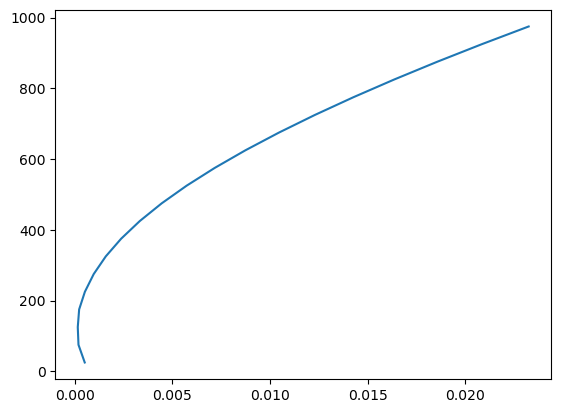

In [5]:
plt.plot(ds.q,ds.lev)

In [32]:
# Get the transient adjusted column

ds=getEquilRadConvColumn()
ds2x = getEquilRadConvColumn(CO2=6.96e-4)

Total elapsed time is 5.996021270269426 years.
Total elapsed time is 6.995358148647664 years.


In [37]:
dsl=[]
m2=getEquilRadConvColumn(return_model=True,water_depth=5)
m2.absorber_vmr['CO2']=6.96e-4
dt=0.25
for i in range(0,20):
    m2.integrate_years(dt)
    dsl.append(m2.to_xarray(diagnostics=True))
dsm=xr.combine_nested(dsl,concat_dim='m')

Total elapsed time is 5.996021270269426 years.
Integrating for 91 steps, 91.31055 days, or 0.25 years.
Total elapsed time is 6.245171012550028 years.
Integrating for 91 steps, 91.31055 days, or 0.25 years.
Total elapsed time is 6.49432075483063 years.
Integrating for 91 steps, 91.31055 days, or 0.25 years.
Total elapsed time is 6.743470497111232 years.
Integrating for 91 steps, 91.31055 days, or 0.25 years.
Total elapsed time is 6.992620239391833 years.
Integrating for 91 steps, 91.31055 days, or 0.25 years.
Total elapsed time is 7.241769981672435 years.
Integrating for 91 steps, 91.31055 days, or 0.25 years.
Total elapsed time is 7.490919723953037 years.
Integrating for 91 steps, 91.31055 days, or 0.25 years.
Total elapsed time is 7.7400694662336385 years.
Integrating for 91 steps, 91.31055 days, or 0.25 years.
Total elapsed time is 7.98921920851424 years.
Integrating for 91 steps, 91.31055 days, or 0.25 years.
Total elapsed time is 8.238368950794841 years.
Integrating for 91 steps, 9

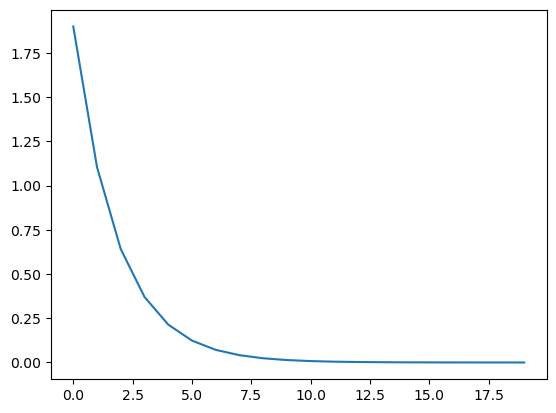

In [38]:
plt.plot(dsm.ASR-dsm.OLR)

In [31]:
m2.integrate_years(0.5)
ds2=m2.to_xarray(diagnostics=True)
print((ds2.ASR-ds2.OLR)-(ds.ASR-ds.OLR))

Integrating for 182 steps, 182.6211 days, or 0.5 years.
Total elapsed time is 8.487518693075444 years.
<xarray.DataArray (depth: 1)> Size: 8B
array([0.01376991])
Coordinates:
  * depth    (depth) float64 8B 2.5


In [15]:
(ds2.ASR-ds2.OLR)-(ds.ASR-ds.OLR)

<xarray.DataArray (depth: 1)> Size: 8B
array([1.10444271])
Coordinates:
  * depth    (depth) float64 8B 2.5

In [8]:
m=getEquilRadConvColumn(albedo=0.25,return_model=True)

Total elapsed time is 6.995358148647664 years.


In [7]:
# compute some kernels 
# looks goofy, but we're going to reuse one model state over and over
# and just perturb it at ever different level

# save the basestate OLR for later 
OLR0 = m.OLR

# surface temperature kernel (1 number)
K_Ts=0
m.Ts += 1.0
m.compute_diagnostics()
K_Ts = m.OLR-OLR0
m.Ts -= 1.0

# atmospheric temperature kernel (profile)
K_Tatm = np.zeros(len(m.lev))
for i in range(0,20):
    m.Tatm[i] += 1.0
    m.compute_diagnostics()
    K_Tatm[i] = m.OLR-OLR0
    m.Tatm[i] -= 1.0

/tmp/ipykernel_37899/2557863802.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  K_Tatm[i] = m.OLR-OLR0


In [10]:
# moisture perturbations found by assuming dRH=0 for dT=1
relHum=0.8
dlnq = climlab.utils.thermo.mixing_ratio_from_vapor_pressure(m.lev,relhum*climlab.thermo.clausius_clapeyron(m.Tatm+1.0)) - \
     climlab.utils.thermo.mixing_ratio_from_vapor_pressure(m.lev,relhum*climlab.thermo.clausius_clapeyron(m.Tatm))
# moisture kernel (profile)
K_q = np.zeros(len(m.lev))
q0 = m.subprocess.Radiation.specific_humidity
state=m.state
OLR0=m.OLR
for i in range(2,20):
    water_vapor = climlab.radiation.water_vapor.FixedRelativeHumidity(state=state,
                                                                        relative_humidity=relHum)
    water_vapor.q[i] += dq[i]  
    radiation = climlab.radiation.CAM3(
                             state=state,
                             specific_humidity=water_vapor.q)
    radiation.compute_diagnostics()
    K_q[i] = radiation.OLR-OLR0

NameError: name 'dq' is not defined

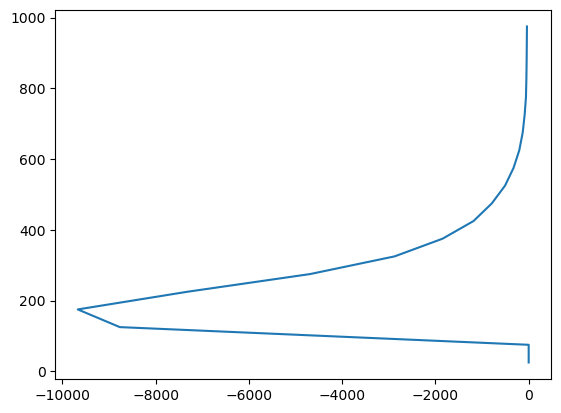

In [ ]:
plt.plot(K_q/dq,m.lev)

In [ ]:
m.state

AttrDict({'Ts': Field([289.41983509]), 'Tatm': Field([212.79434409, 212.30925253, 213.18023136, 215.93517231,
       222.68835422, 230.68058096, 237.55229207, 243.60124311,
       249.01810164, 253.93276422, 258.43794772, 262.60228378,
       266.47808258, 270.10618322, 273.51911608, 276.7432389 ,
       279.80022344, 282.70811715, 285.48211822, 288.13515261])})

In [ ]:
relHum=0.8
print(OLR1-OLR0)

[9.81078758e-05]


In [ ]:
vars(m.subprocess.Radiation)

{'tendencies': {'Ts': Field([1.8565171e-06]),
  'Tatm': Field([-9.63783101e-07, -2.23372695e-07,  1.11091167e-07,  1.54790805e-08,
         -3.67258322e-06, -7.63489883e-06, -9.01394908e-06, -9.33107320e-06,
         -8.57431777e-06, -8.69563732e-06, -7.84441722e-06, -6.23591039e-06,
         -4.47419242e-06, -2.82232770e-06, -1.27807040e-06,  1.02411219e-06,
          8.81018302e-07,  1.34181130e-07, -1.38349334e-06, -3.17588238e-06])},
 'verbose': True,
 'name': 'Radiation',
 'domains': {'Ts': <climlab.domain.domain.SlabOcean at 0x7f35e6520910>,
  'Tatm': <climlab.domain.domain.Atmosphere at 0x7f35db3d7290>},
 'state': AttrDict({'Ts': Field([289.41983509]), 'Tatm': Field([212.79434409, 212.30925253, 213.18023136, 215.93517231,
        222.68835422, 230.68058096, 237.55229207, 243.60124311,
        249.01810164, 253.93276422, 258.43794772, 262.60228378,
        266.47808258, 270.10618322, 273.51911608, 276.7432389 ,
        279.80022344, 282.70811715, 285.48211822, 288.13515261])}),
 

In [ ]:
m.subprocess.Radiation._compute_LW_flux_diagnostics()

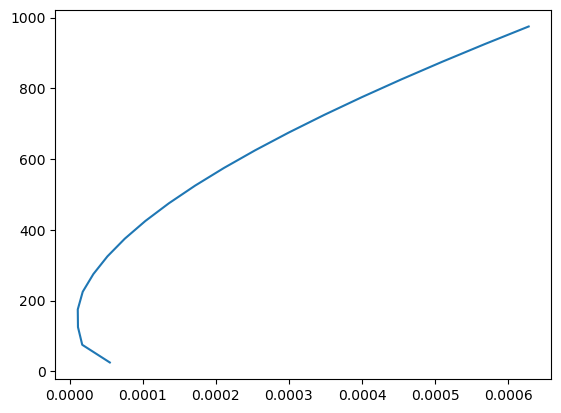

In [ ]:
plt.plot(dq,m.lev)

In [ ]:
print(ds.OLR-ds.ASR)
print(ds2.OLR-ds2.ASR)
print(ds3.OLR-ds3.ASR)

<xarray.DataArray (depth: 1)> Size: 8B
array([-4.75475758e-07])
Coordinates:
  * depth    (depth) float64 8B 2.5
<xarray.DataArray (depth: 1)> Size: 8B
array([-0.95100638])
Coordinates:
  * depth    (depth) float64 8B 2.5
<xarray.DataArray (depth: 1)> Size: 8B
array([-4.75737465e-07])
Coordinates:
  * depth    (depth) float64 8B 2.5


Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 7.994695027025902 years.


In [ ]:
m

In [ ]:

m=getEquilRadConvColumn(return_model=True,water_depth=20)

m.absorber_vmr['CO2']=2*m.absorber_vmr['CO2']

dsl=[]
dsl.append(m.to_xarray(diagnostics=True))

for i in range(0,20):
    m.integrate_years(0.1)
    dsl.append(m.to_xarray(diagnostics=True))

dsn=xr.combine_nested(dsl,concat_dim='t')


Total elapsed time is 15.989390054051803 years.
Integrating for 36 steps, 36.52422000000001 days, or 0.1 years.
Total elapsed time is 16.08795478726171 years.
Integrating for 36 steps, 36.52422000000001 days, or 0.1 years.
Total elapsed time is 16.18651952047162 years.
Integrating for 36 steps, 36.52422000000001 days, or 0.1 years.
Total elapsed time is 16.28508425368153 years.
Integrating for 36 steps, 36.52422000000001 days, or 0.1 years.
Total elapsed time is 16.383648986891437 years.
Integrating for 36 steps, 36.52422000000001 days, or 0.1 years.
Total elapsed time is 16.482213720101345 years.
Integrating for 36 steps, 36.52422000000001 days, or 0.1 years.
Total elapsed time is 16.580778453311254 years.
Integrating for 36 steps, 36.52422000000001 days, or 0.1 years.
Total elapsed time is 16.679343186521162 years.
Integrating for 36 steps, 36.52422000000001 days, or 0.1 years.
Total elapsed time is 16.77790791973107 years.
Integrating for 36 steps, 36.52422000000001 days, or 0.1 yea

In [ ]:
    state = climlab.column_state(num_lev=len(input_state_Tatm), num_lat=1)
    state['Ts'][:] = input_state_Ts
    state['Tatm'][:] = input_state_Tatm

    water_vapor = climlab.radiation.water_vapor.FixedRelativeHumidity(state=state,
                                                                        relative_humidity=relHum)

    radiation = climlab.radiation.CAM3(name='Radiation',
                             state=state,
                             specific_humidity=water_vapor.q,
                             absorber_vmr=ghgDict,
                             cldfrac=cldfrac,
                             clwp=clwp,
                             ciwp=ciwp,
                             r_liq=r_liq,
                             r_ice=r_ice,
                             insolation=insolation,
                             return_spectral_olr=True,
                             albedo=albedo)

    radiation.compute_diagnostics()

    # output the data as an xarray dataset
    return radiation.to_xarray(diagnostics=True)


In [ ]:
print(m.OLR)
m.Ts+=2
m.compute_diagnostics()
print(m.OLR)

<xarray.DataArray 'OLR' (depth: 1)> Size: 8B
array([257.13702013])
Coordinates:
  * depth    (depth) float64 8B 2.5


AttributeError: cannot set attribute 'Ts' on a 'Dataset' object. Use __setitem__ styleassignment (e.g., `ds['name'] = ...`) instead of assigning variables.

In [ ]:
dsn.Ts

<xarray.DataArray 'Ts' (t: 21, depth: 1)> Size: 168B
array([[303.27744415],
       [303.27744415],
       [303.27744415],
       [303.27744415],
       [303.27744415],
       [303.27744415],
       [303.27744415],
       [303.27744415],
       [303.27744415],
       [303.27744415],
       [303.27744415],
       [303.27744415],
       [303.27744415],
       [303.27744415],
       [303.27744415],
       [303.27744415],
       [303.27744415],
       [303.27744415],
       [303.27744415],
       [303.27744415],
       [303.27744415]])
Coordinates:
  * depth    (depth) float64 8B 10.0
Dimensions without coordinates: t

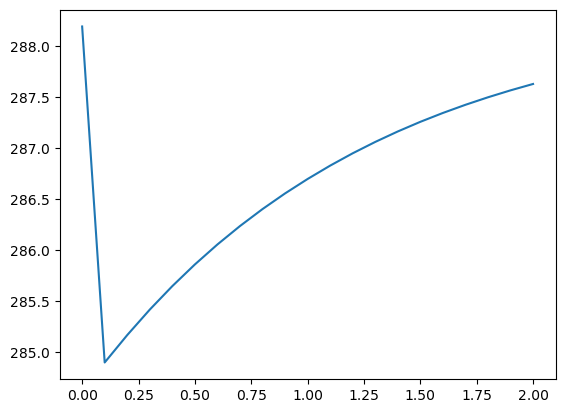

In [ ]:
plt.plot(dsn.t*0.1,dsn.OLR)

In [ ]:
dsn.Ts

<xarray.DataArray 'Ts' (t: 21, depth: 1)> Size: 168B
array([[303.56019616],
       [303.56019616],
       [303.56019616],
       [303.56019616],
       [303.56019616],
       [303.56019616],
       [303.56019616],
       [303.56019616],
       [303.56019616],
       [303.56019616],
       [303.56019616],
       [303.56019616],
       [303.56019616],
       [303.56019616],
       [303.56019616],
       [303.56019616],
       [303.56019616],
       [303.56019616],
       [303.56019616],
       [303.56019616],
       [303.56019616]])
Coordinates:
  * depth    (depth) float64 8B 2.5
Dimensions without coordinates: t

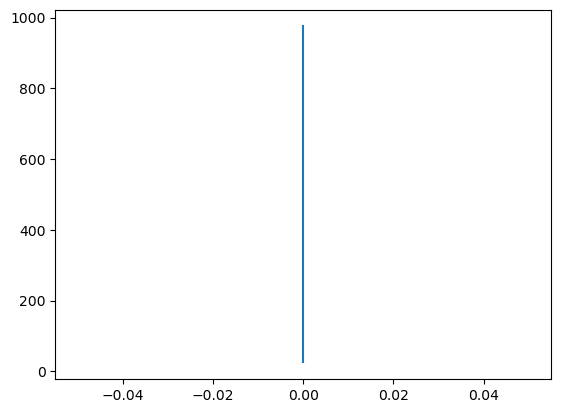

In [ ]:
plt.plot(dsn.Tatm.sel(t=20)-dsn.Tatm.sel(t=0),dsn.lev)

In [ ]:
m.absorber_vmr['CO2']=m.absorber_vmr['CO2']

0.000348

In [ ]:
vars(m)

{'tendencies': {'Ts': Field([3.09358795e-12]),
  'Tatm': Field([1.29968376e-13, 3.91473012e-13, 9.33261602e-13, 2.27747407e-12,
         2.38029971e-12, 2.46572809e-12, 2.53917973e-12, 2.60383621e-12,
         2.66173667e-12, 2.71426929e-12, 2.76242466e-12, 2.80693691e-12,
         2.84836518e-12, 2.88714592e-12, 2.92362598e-12, 2.95808860e-12,
         2.99076442e-12, 3.02184653e-12, 3.05149831e-12, 3.07985591e-12])},
 'verbose': True,
 'name': 'RadConv',
 'domains': {'Ts': <climlab.domain.domain.SlabOcean at 0x7f35e5f32750>,
  'Tatm': <climlab.domain.domain.Atmosphere at 0x7f35e5fac250>},
 'state': AttrDict({'Ts': Field([302.05977025]), 'Tatm': Field([213.22079501, 213.89692851, 215.83304616, 222.37392373,
        232.41390174, 240.75517584, 247.92699763, 254.24012665,
        259.89355756, 265.02285995, 269.72479993, 274.07100652,
        278.11607445, 281.90262642, 285.46461351, 288.82954458,
        292.02003789, 295.05492908, 297.95008008, 300.71898139])}),
 'Ts': Field([302.0597

In [ ]:

state = climlab.column_state(num_lev=20,
                                num_lat=1,
                                water_depth=5.)

water_vapor = climlab.radiation.water_vapor.ManabeWaterVapor(state=state,
                                                                    relative_humidity=0.8,
                                                                    name='Manabe Relative Humidity')

radiation = climlab.radiation.CAM3(name='Radiation',
                            state=state,
                            specific_humidity=water_vapor.q)

convection = climlab.convection.ConvectiveAdjustment(name='Convective Adjustment',
                                                state=state,
                                                adj_lapse_rate=6.5)
    
model = climlab.couple([radiation,convection,water_vapor], name='RadConv')


In [ ]:
dsl=[]
for i in range(0,50):
    model.integrate_years(0.1)
    dsl.append(model.to_xarray(diagnostics=True))

dsn=xr.combine_nested(dsl,concat_dim='t')
#plt.plot(model.Tatm,model.lev)

Integrating for 36 steps, 36.52422000000001 days, or 0.1 years.
Total elapsed time is 5.125366126915235 years.
Integrating for 36 steps, 36.52422000000001 days, or 0.1 years.
Total elapsed time is 5.223930860125144 years.
Integrating for 36 steps, 36.52422000000001 days, or 0.1 years.
Total elapsed time is 5.322495593335052 years.
Integrating for 36 steps, 36.52422000000001 days, or 0.1 years.
Total elapsed time is 5.421060326544961 years.
Integrating for 36 steps, 36.52422000000001 days, or 0.1 years.
Total elapsed time is 5.519625059754869 years.
Integrating for 36 steps, 36.52422000000001 days, or 0.1 years.
Total elapsed time is 5.6181897929647775 years.
Integrating for 36 steps, 36.52422000000001 days, or 0.1 years.
Total elapsed time is 5.716754526174686 years.
Integrating for 36 steps, 36.52422000000001 days, or 0.1 years.
Total elapsed time is 5.815319259384594 years.
Integrating for 36 steps, 36.52422000000001 days, or 0.1 years.
Total elapsed time is 5.913883992594503 years.


In [ ]:
dsn=xr.combine_nested(dsl,concat_dim='t')

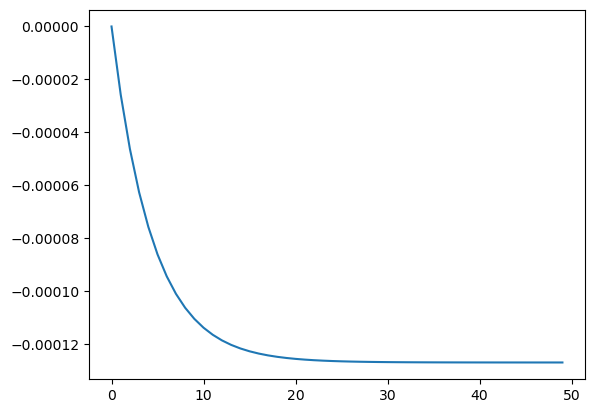

In [ ]:
plt.plot(dsn.OLR-dsn.OLR[0])

In [ ]:
def makePlotsFromExperimentList(rl,labell,
colorlist=['black','blue','red','green','orange','purple'],
plotDiff=False,
outputname=None
):

    titles=['T (K)','q(kg/kg)','','SW Flux (W/m^2)','LW Flux (W/m^2)','Heating Rates (K/day)']

    fig,axs=plt.subplots(2,3,figsize=(12,10),dpi=100)

    fig.delaxes(axs[0,-1])

    nl=range(0,len(rl))

    for n,r,l,c in zip(nl,rl,labell,colorlist):

        if plotDiff:
            r=r-rl[0]

        # temperature
        axs[0,0].plot(r.Tatm,r.lev,
                    label=l,color=c)

        # moisture
        axs[0,1].plot(r.q,r.lev,
                      label=l,color=c)

        if n==0:
            label0='FluxUp'
            label1='FluxDown'
            label2='FluxNet'
        else:
            label0=None
            label1=None
            label2=None
 
        # shortwave
        axs[1,0].plot(r.SW_flux_up,r.lev_bounds,
                      label=label0,color=c,linestyle='--')
        axs[1,0].plot(r.SW_flux_down,r.lev_bounds,
                      label=label1,color=c,linestyle='-.')
        axs[1,0].plot(r.SW_flux_net,r.lev_bounds,
                      label=label2,color=c,linestyle='-')
        
        # longwave
        axs[1,1].plot(r.LW_flux_up,r.lev_bounds,
                      label=label0,color=c,linestyle='--')
        axs[1,1].plot(r.LW_flux_down,r.lev_bounds,
                      label=label1,color=c,linestyle='-.')
        axs[1,1].plot(r.LW_flux_net,r.lev_bounds,
                      label=label2,color=c,linestyle='-')
        
        if n==0:
            label0='SW'
            label1='LW'
            label2='Conv'
        else:
            label0=None
            label1=None
            label2=None

        # heating rates
        axs[1,2].plot(r.TdotSW,r.lev,
                        color=c,label=label0,linestyle='--')
        axs[1,2].plot(r.TdotLW,r.lev,
                        color=c,label=label1,linestyle='-.')
        axs[1,2].plot(-r.TdotLW-r.TdotSW,r.lev,
                        color=c,label=label2,linestyle='-')

    for i,j in product(range(0,2),range(0,3)):
        axs[i,j].set_ylim([1e3,0])
        axs[i,j].set_title(titles[3*i+j])
        axs[i,j].set_ylabel('p (hPa)')

    axs[0,0].legend()
    axs[1,0].legend()
    axs[1,-1].legend()

    fig.tight_layout()

    if not outputname is None:
        plt.savefig(outputname)

    plt.show()

In [ ]:
r0 = getRadConvColumnData()
r1 = getRadConvColumnData(do_conv=False)

Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 4.999422301147019 years.
Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 4.999422301147019 years.


In [ ]:
r0

<xarray.Dataset> Size: 3kB
Dimensions:           (depth: 1, lev: 20, lev_bounds: 21, depth_bounds: 2)
Coordinates:
  * depth             (depth) float64 8B 2.5
  * lev               (lev) float64 160B 25.0 75.0 125.0 ... 875.0 925.0 975.0
  * depth_bounds      (depth_bounds) float64 16B 0.0 5.0
  * lev_bounds        (lev_bounds) float64 168B 0.0 50.0 100.0 ... 950.0 1e+03
Data variables: (12/29)
    Ts                (depth) float64 8B 294.2
    Tatm              (lev) float64 160B 234.4 218.7 215.8 ... 287.4 290.2 292.9
    OLR               (depth) float64 8B 286.8
    OLRclr            (depth) float64 8B 286.8
    OLRcld            (depth) float64 8B 0.0
    TdotLW            (lev) float64 160B -2.668 -0.4953 ... -0.8869 -1.086
    ...                ...
    SW_flux_down      (lev_bounds) float64 168B 341.0 324.0 ... 221.4 215.6
    SW_flux_net       (lev_bounds) float64 168B 286.8 271.0 ... 198.5 194.0
    SW_flux_up_clr    (lev_bounds) float64 168B 54.15 52.94 ... 22.82 21.56
    SW_flux_down_clr  (lev_bounds) float64 168B 341.0 324.0 ... 221.4 215.6
    SW_flux_net_clr   (lev_bounds) float64 168B 286.8 271.0 ... 198.5 194.0
    q                 (lev) float64 160B 2.187e-05 1.405e-05 ... 0.00965 0.01144

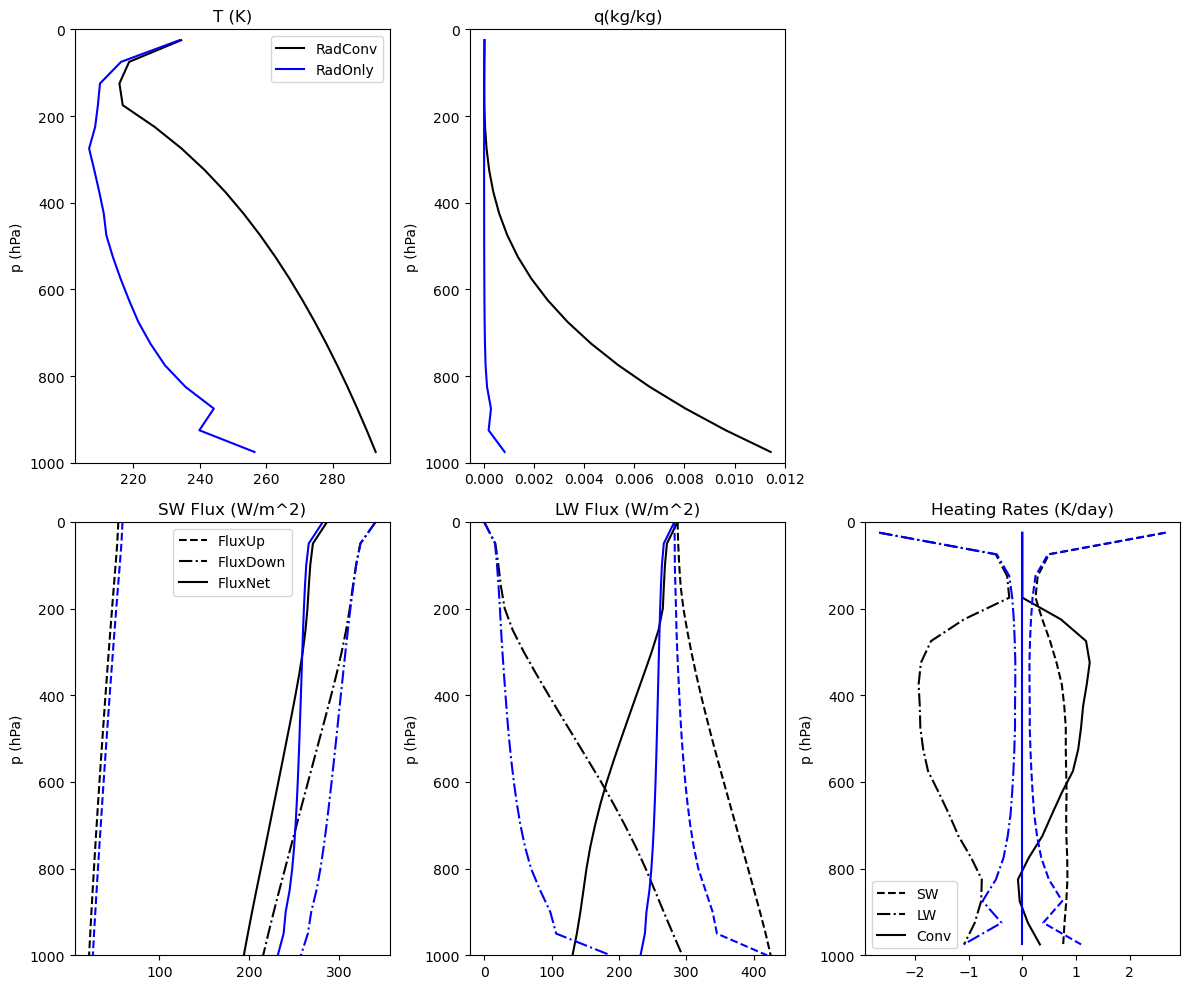

In [ ]:
makePlotsFromExperimentList([r0,r1],['RadConv','RadOnly'])

In [ ]:
lrl = [3,9.8]
rl=[]
labelsl=[]
for lr in lrl:
    rl.append(getRadConvColumnData(lapseRate=lr))

Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 4.999422301147019 years.
Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 4.999422301147019 years.


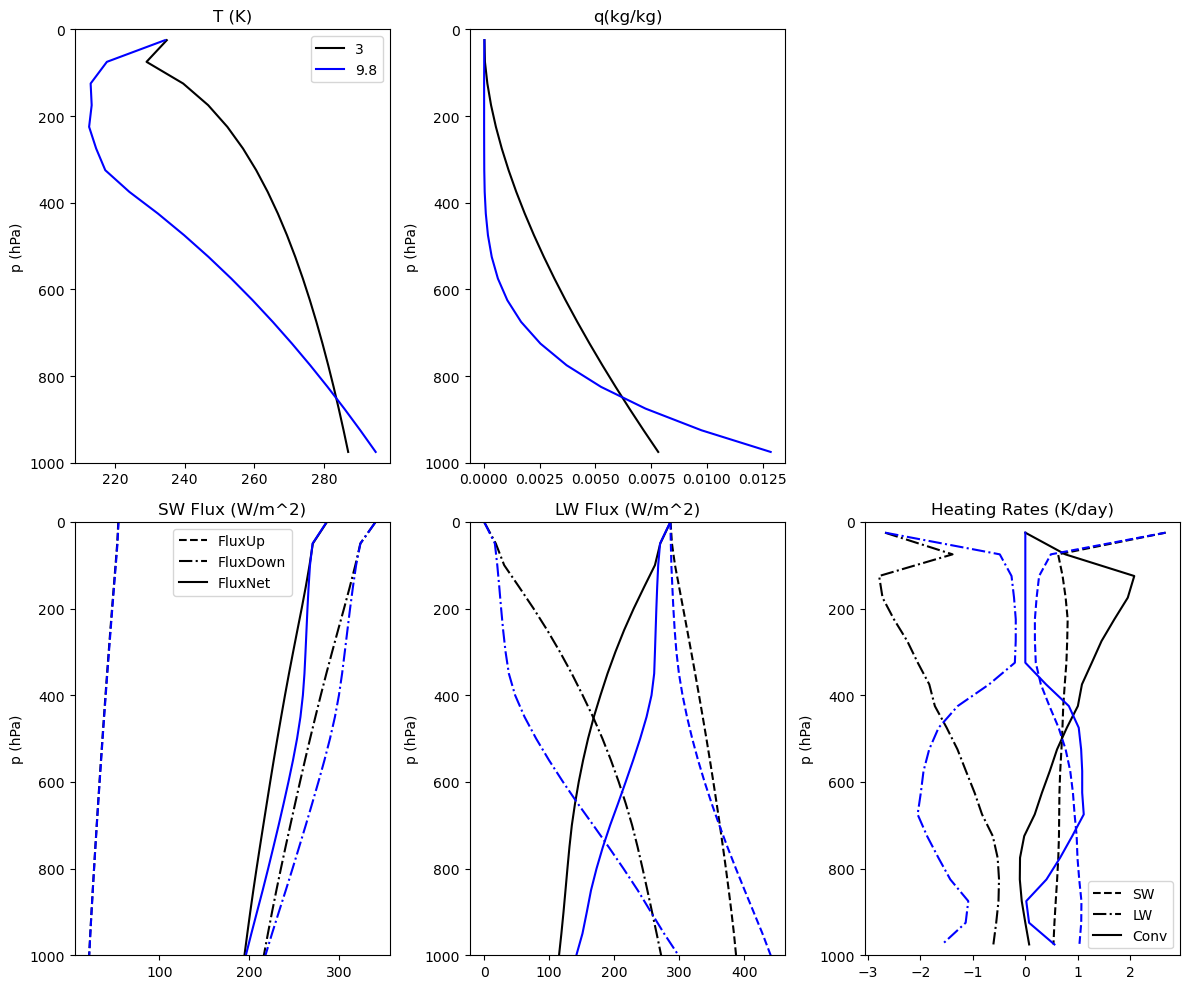

In [ ]:
makePlotsFromExperimentList(rl,lrl,plotDiff=False)

In [ ]:

nlev = len(r0.lev)

r0 = getRadConvColumnData()

ilo=-4
cldfaclo=np.zeros(nlev);clplo=np.zeros(nlev); ciplo=np.zeros(nlev)
cldfaclo[ilo]=1; clplo[ilo]=100.; ciplo[ilo]=0.0


ihi=2
print(r0.lev[ihi])
cldfachi=np.zeros(nlev); clphi=np.zeros(nlev); ciphi=np.zeros(nlev); 
cldfachi[ihi]=1; clphi[ihi]=29; ciphi[ihi]=0

clo = getRadConvColumnData(
        cldfrac=cldfaclo, 
        clwp=clplo, 
        ciwp = ciplo,  
        r_liq = 15,
        r_ice = 15,
        )

chi = getRadConvColumnData(
        cldfrac=cldfachi, 
        clwp=clphi, 
        ciwp = ciphi,  
        r_liq = 15,
        r_ice = 15,
        )

makePlotsFromExperimentList([r0,clo,chi],['reference','low cloud','high cloud'],plotDiff=True)


Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 4.999422301147019 years.
<xarray.DataArray 'lev' ()> Size: 8B
array(125.)
Coordinates:
    lev      float64 8B 125.0
Attributes:
    units:    mb
Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 4.999422301147019 years.
Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 4.999422301147019 years.


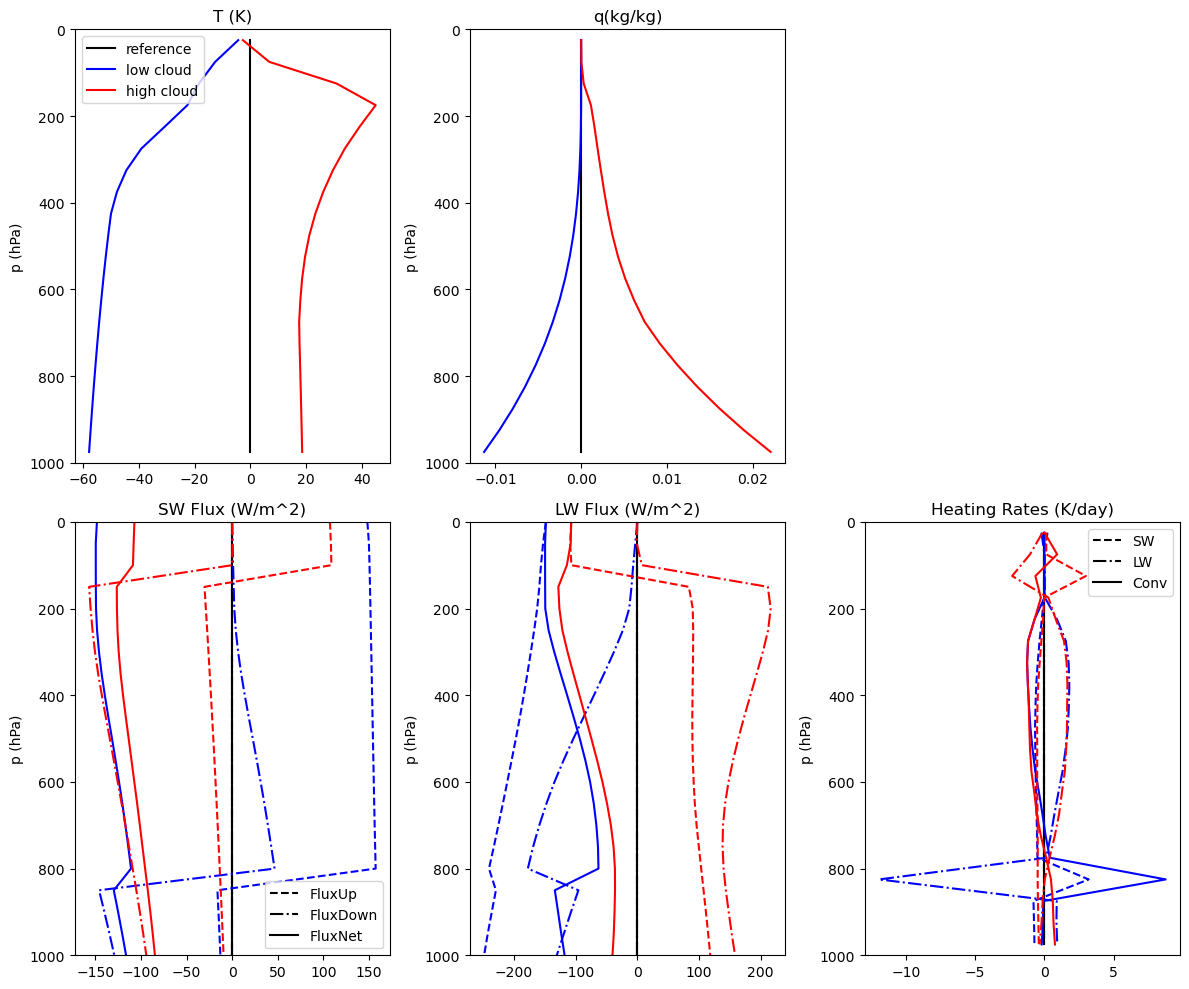

Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 4.999422301147019 years.
Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 4.999422301147019 years.
Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 4.999422301147019 years.
Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 4.999422301147019 years.


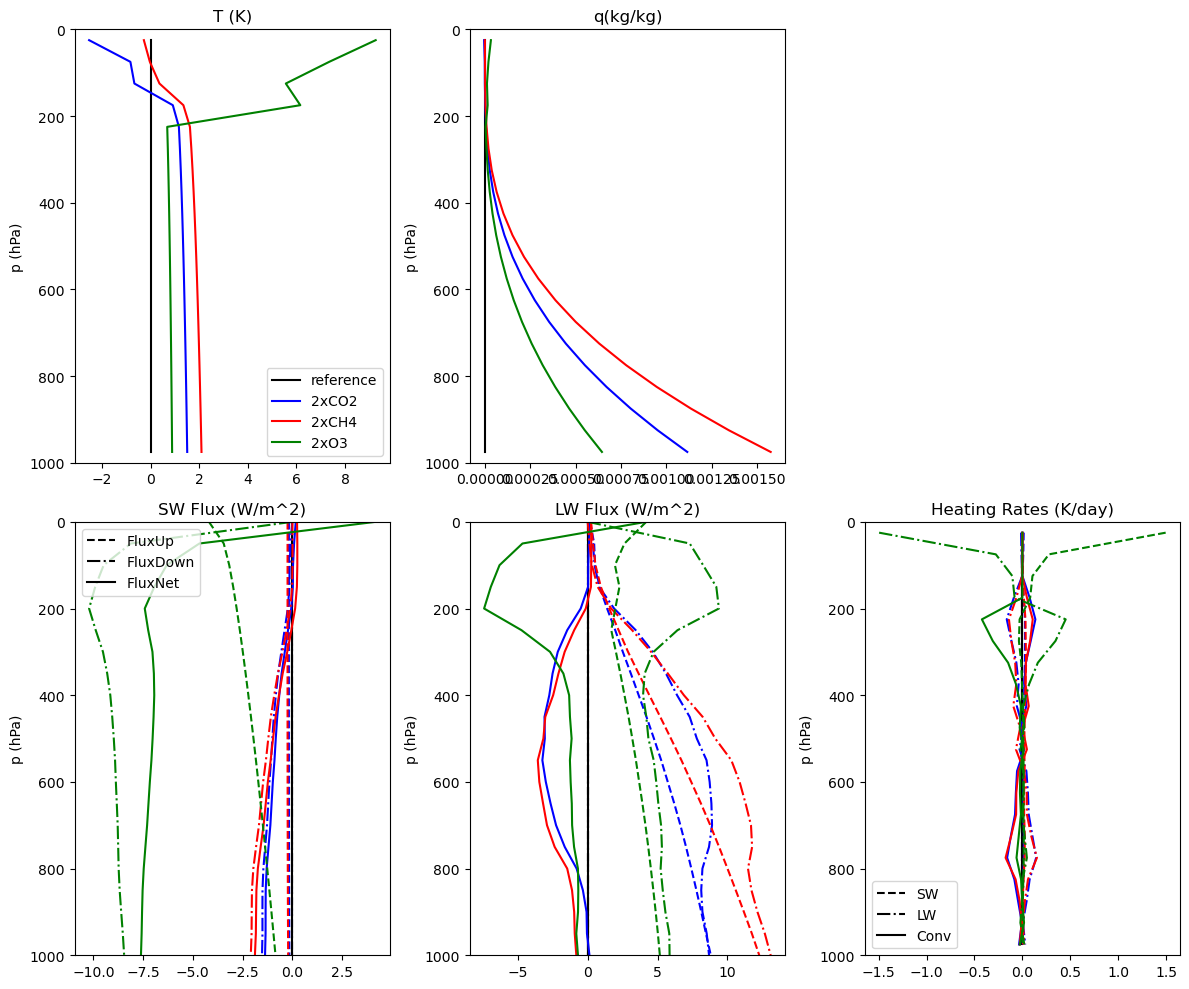

In [ ]:
s0 = getRadConvColumnData()
s1 = getRadConvColumnData(CO2=0.000348*2)
s2 = getRadConvColumnData(CH4=1.65e-06*20)
s3 = getRadConvColumnData(O3fac=2)
makePlotsFromExperimentList([s0,s1,s2,s3],['reference','2xCO2','2xCH4','2xO3'],plotDiff=True)


In [ ]:
def getOLRDiagnostic(
        input_state_Ts,
        input_state_Tatm,
        relHum=0.8,
        CO2=0.000348,
        CH4=1.65e-06,
        N2O=3.06e-07,
        O2=0.21,
        CFC11=0.0,
        CFC12=0.0,
        CFC22=0.0,
        CCL4=0.0,
        O3_profile=np.array([5.38853507e-06, 9.86362297e-07, 3.46334801e-07, 1.90806332e-07,
                                    1.19700066e-07, 7.69083554e-08, 5.97316411e-08, 5.27011190e-08,
                                    4.80406196e-08, 4.44967931e-08, 4.18202246e-08, 3.99595858e-08,
                                    3.83838549e-08, 3.66179869e-08, 3.42885526e-08, 3.18505117e-08,
                                    2.93003951e-08, 2.69906527e-08, 2.49122466e-08, 2.28798533e-08]),
        O3fac=1.0,
        insolation=341.,
        cldfrac=0., 
        clwp=0., 
        ciwp = 0.,
        r_liq = 0.,
        r_ice = 0.,
        albedo=0.1,
        ):

    # get the different components of the model
    # state - container for the vertical temperature profile
    # water vapour - set moisture based on relative humidity profile        
    # radiation - RRTM spectral radiation 

    # create the ghg dict
    ghgDict = {'CO2': CO2,
                'CH4': CH4,
                'N2O': N2O,
                'O2': O2,
                'CFC11': CFC11,
                'CFC12': CFC12,
                'CFC22': CFC22,
                'CCL4': CCL4,
                'O3': O3fac*O3_profile}

    # this is necessary because we output the states to xarray,
    # so have to convert back to state.    
    state = climlab.column_state(num_lev=len(input_state_Tatm), num_lat=1)
    state['Ts'][:] = input_state_Ts
    state['Tatm'][:] = input_state_Tatm

    water_vapor = climlab.radiation.water_vapor.FixedRelativeHumidity(state=state,
                                                                        relative_humidity=relHum)

    radiation = climlab.radiation.CAM3(name='Radiation',
                             state=state,
                             specific_humidity=water_vapor.q,
                             absorber_vmr=ghgDict,
                             cldfrac=cldfrac,
                             clwp=clwp,
                             ciwp=ciwp,
                             r_liq=r_liq,
                             r_ice=r_ice,
                             insolation=insolation,
                             return_spectral_olr=True,
                             albedo=albedo)

    radiation.compute_diagnostics()

    # output the data as an xarray dataset
    return radiation.to_xarray(diagnostics=True)


Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 4.999422301147019 years.
Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 4.999422301147019 years.


(1000.0, 0.0)

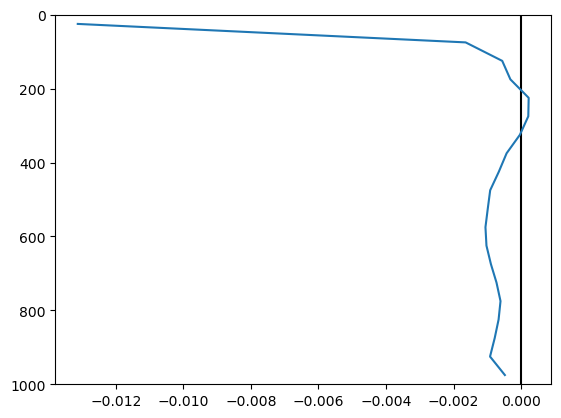

In [ ]:
s = getRadConvColumnData()
s2 = getRadConvColumnData(CO2=2*0.000348)

OLR0 = getOLRDiagnostic(s.Ts,s.Tatm).OLR
K = np.zeros(20)
for i in range(0,20):
    pert = np.zeros(20)
    pert[i] = 1
    OLR1 = getOLRDiagnostic(s.Ts,s.Tatm+pert).OLR
    K[i] = -(OLR1 - OLR0)/50


plt.axvline(0,color='k')
plt.plot(K,s.lev)
plt.ylim([1e3,0])
#plt.xlim([-0.05,0.05])

In [ ]:
s3 = getRadConvColumnData(CO2=2*0.000348,integrate_years=1)


Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 0.9993368783782377 years.


In [ ]:
s3.OLR-s.OLR

<xarray.DataArray 'OLR' (depth: 1)> Size: 8B
array([-1.80905925])
Coordinates:
  * depth    (depth) float64 8B 2.5

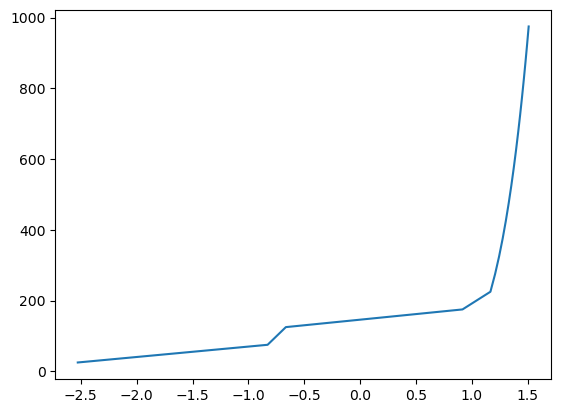

In [ ]:
plt.plot(s2.Tatm-s.Tatm,s.lev)

In [ ]:
s.Ts

<xarray.DataArray 'Ts' (depth: 1)> Size: 8B
array([287.53650928])
Coordinates:
  * depth    (depth) float64 8B 2.5

array([-32.81607481,  -4.11071516,  -1.40122523,  -0.79815597,
         0.55592433,   0.52717317,  -0.09381977,  -1.07779161,
        -1.65452341,  -2.29252058,  -2.47215265,  -2.64283787,
        -2.56827894,  -2.23826403,  -1.82432518,  -1.52848819,
        -1.67121005,  -1.95853974,  -2.30390441,  -1.20666946])

(-0.05, 0.05)

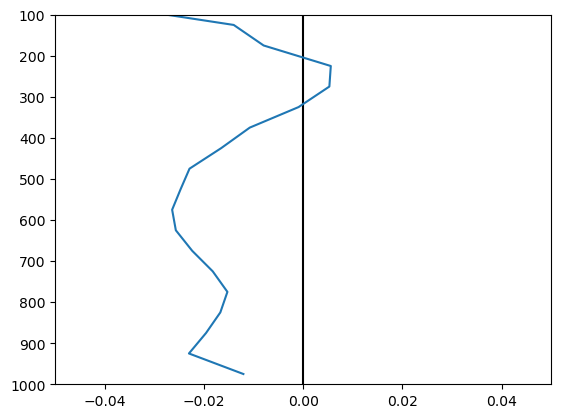

In [ ]:
getOLRDiagnostic(s.Ts+1,s.Tatm).OLR-OLR0

<xarray.DataArray 'OLR' (depth: 1)> Size: 8B
array([1.95932624])
Coordinates:
  * depth    (depth) float64 8B 0.5

In [ ]:
m.q

Field([0.00037998, 0.00013804, 0.00010559, 0.00016524, 0.00038821,
       0.0007346 , 0.00121432, 0.00183158, 0.00258679, 0.0034779 ,
       0.00450131, 0.0056524 , 0.00692602, 0.00831671, 0.0098189 ,
       0.01142706, 0.01313574, 0.01493967, 0.01683374, 0.01881308])

In [ ]:
H = m.q / climlab.utils.thermo.mixing_ratio_from_vapor_pressure(m.lev,climlab.thermo.clausius_clapeyron(m.Tatm))
print(H)
Hn = H + 0.01
qn = H * climlab.utils.thermo.mixing_ratio_from_vapor_pressure(m.lev,climlab.thermo.clausius_clapeyron(m.Tatm))
m.q = qn

[0.79938898 0.79977803 0.79983021 0.79973429 0.79937575 0.79881875
 0.79804735 0.7970548  0.79584041 0.79440748 0.79276183 0.79091086
 0.78886286 0.78662661 0.78421107 0.78162512 0.77887754 0.77597681
 0.77293111 0.76974831]


Field([-3.42023361, -3.85999972, -3.97638244, -3.78188192, -3.41093242,
       -3.13394742, -2.91566595, -2.73717498, -2.58723954, -2.45868236,
       -2.34666113, -2.24776682, -2.15951608, -2.08004843, -2.00793698,
       -1.94206541, -1.88154531, -1.82565906, -1.7738194 , -1.7255402 ])

<BarContainer object of 16 artists>

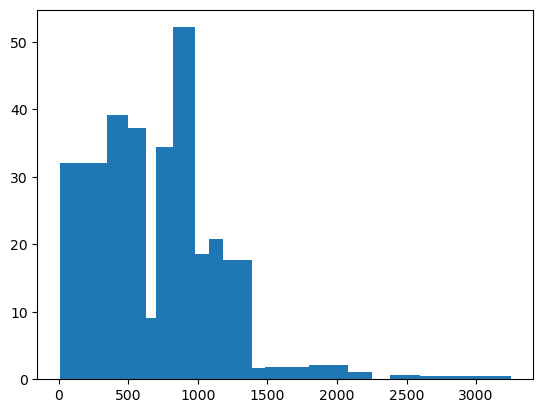

In [ ]:

plt.bar(x=r.wavenumber.data, width=r.wavenumber_bounds.data[1:] - r.wavenumber_bounds.data[:-1], height=r.OLR_spectral[0])

In [ ]:
radiation.compute_diagnostics()

In [ ]:
s

<xarray.Dataset> Size: 3kB
Dimensions:           (depth: 1, lev: 20, lev_bounds: 21, depth_bounds: 2)
Coordinates:
  * depth             (depth) float64 8B 2.5
  * lev               (lev) float64 160B 25.0 75.0 125.0 ... 875.0 925.0 975.0
  * depth_bounds      (depth_bounds) float64 16B 0.0 5.0
  * lev_bounds        (lev_bounds) float64 168B 0.0 50.0 100.0 ... 950.0 1e+03
Data variables: (12/29)
    Ts                (depth) float64 8B 302.1
    Tatm              (lev) float64 160B 213.2 213.9 215.8 ... 295.1 298.0 300.7
    OLR               (depth) float64 8B 288.2
    OLRclr            (depth) float64 8B 288.2
    OLRcld            (depth) float64 8B 0.0
    TdotLW            (lev) float64 160B -3.182 -0.6771 -0.412 ... -1.163 -1.425
    ...                ...
    SW_flux_down      (lev_bounds) float64 168B 341.0 320.9 ... 209.4 204.1
    SW_flux_net       (lev_bounds) float64 168B 288.2 269.3 ... 187.7 183.7
    SW_flux_up_clr    (lev_bounds) float64 168B 52.8 51.59 49.7 ... 21.67 20.41
    SW_flux_down_clr  (lev_bounds) float64 168B 341.0 320.9 ... 209.4 204.1
    SW_flux_net_clr   (lev_bounds) float64 168B 288.2 269.3 ... 187.7 183.7
    q                 (lev) float64 160B 0.00038 0.000138 ... 0.01683 0.01881

In [ ]:
help(type(climlab.radiation.CAM3))

Help on class type in module builtins:

class type(object)
 |  type(object) -> the object's type
 |  type(name, bases, dict, **kwds) -> a new type
 |  
 |  Methods defined here:
 |  
 |  __call__(self, /, *args, **kwargs)
 |      Call self as a function.
 |  
 |  __delattr__(self, name, /)
 |      Implement delattr(self, name).
 |  
 |  __dir__(self, /)
 |      Specialized __dir__ implementation for types.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __instancecheck__(self, instance, /)
 |      Check if an object is an instance.
 |  
 |  __or__(self, value, /)
 |      Return self|value.
 |  
 |  __repr__(self, /)
 |      Return repr(self).
 |  
 |  __ror__(self, value, /)
 |      Return value|self.
 |  
 |  __setattr__(self, name, value, /)
 |      Implement setattr(self, name, value).
 |  
 |  __sizeof__(self, /)
 |      Return mem

In [ ]:
climlab.column_state.T

AttributeError: 'function' object has no attribute 'T'